In [1]:
import json
import os
import glob
import urllib
import functools
import itertools

import pandas as pd
# import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Downloads contract json files and loads it into DATA

if not os.path.exists("data"):
    os.makedirs("data")
    
for url in (
    "https://techinquiry.org/SiliconValley-Military/subcontracts/microsoft_cloud.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/microsoft_noncloud.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/amazon.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/google.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/facebook.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/nvidia.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/twitter.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/palantir.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/ida.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/mitre.json",
    "https://techinquiry.org/SiliconValley-Military/subcontracts/johns_hopkins.json"
):
    
    path = os.path.join('./data/', url.split('/')[-1])

    if not os.path.isfile(path):
        urllib.request.urlretrieve(url, path)

DATA = {}

for path in glob.glob('./data/*.json'):
    company_name = os.path.splitext(os.path.basename(path))[0]
    
    with open(path, 'r') as f:
        DATA[company_name] = json.load(f)
    


In [3]:
# flatten data in a map of company name to list of contracts
# adds "passthrough_amount" using the "estimated_passthrough_rate"

CONTRACTS = {}

for company in DATA.keys():
    company_contracts = []
    
    for intermediary in DATA[company]:
        for agency in DATA[company][intermediary]:
            for contract in DATA[company][intermediary][agency]:

                # json data uses two different keys -- mistake in original data?
                if "estimated_passthrough_percent" in contract:
                    passthrough_key = "estimated_passthrough_percent"
                else:
                    passthrough_key = "estimated_passthrough_rate"
                                
                company_contracts.append(
                    contract | 
                    { "intermediary": intermediary, "agency":  agency } |
                    { "passthrough_amount": (float(contract[passthrough_key]) / 100) * float(contract["base_and_all_options_value"]) }
                )
    
    CONTRACTS[company] = company_contracts


In [4]:
stats = {}

for company, contracts in CONTRACTS.items():
        stats[company] = sum(map(lambda x: x["passthrough_amount"], contracts))

# sort by amount 
stats = dict(sorted(stats.items(), key=lambda x: x[1], reverse=True))

# format as currency string
{k: '${:0,.2f}'.format(v) for k, v in stats.items()}


{'microsoft_cloud': '$14,906,389,278.88',
 'microsoft_noncloud': '$4,217,538,894.55',
 'amazon': '$163,221,830.57',
 'google': '$32,412,607.80',
 'nvidia': '$7,791,968.60',
 'palantir': '$7,669,369.97',
 'facebook': '$2,895,770.61',
 'twitter': '$805,161.79',
 'mitre': '$741,910.26',
 'ida': '$205,353.67',
 'johns_hopkins': '$27,857.50'}

In [5]:
def get_year_range():
    years = set()
    
    for company, contracts in CONTRACTS.items():
        for contract in contracts:
            years.add(int(contract['signed_date'][0:4]))
    
    return list(range(min(years), max(years) + 1))
    
years = get_year_range()


In [6]:
contracts_by_year = {}

def group_by_year(contracts):
    # year --> { "count", "sum" }
    summary = {}
    #  return value. [{ "count", "sum" }] for each year
    data = []
    
    get_contract_year = lambda x: x['signed_date'][0:4]
    
    for k, g in itertools.groupby(sorted(contracts, key=get_contract_year), get_contract_year):
        contract_group = list(g)
        c = len(contract_group)
        s = round(sum(map(lambda x: x['passthrough_amount'], contract_group)), 2)
        
        summary[k] = { "count": c, "sum": s }
        
    for year in map(str, years):
        if year in summary:
            data.append(summary[year])
        else:
            data.append({"count": 0, "sum": 0})
        
    return data
        
for company, contracts in CONTRACTS.items():
    contracts_by_year[company] =  group_by_year(contracts)

In [7]:
count_df = pd.DataFrame(
    {k: list(map(lambda x: x['count'], v)) for k, v in contracts_by_year.items()},
    index=years
)

<AxesSubplot:>

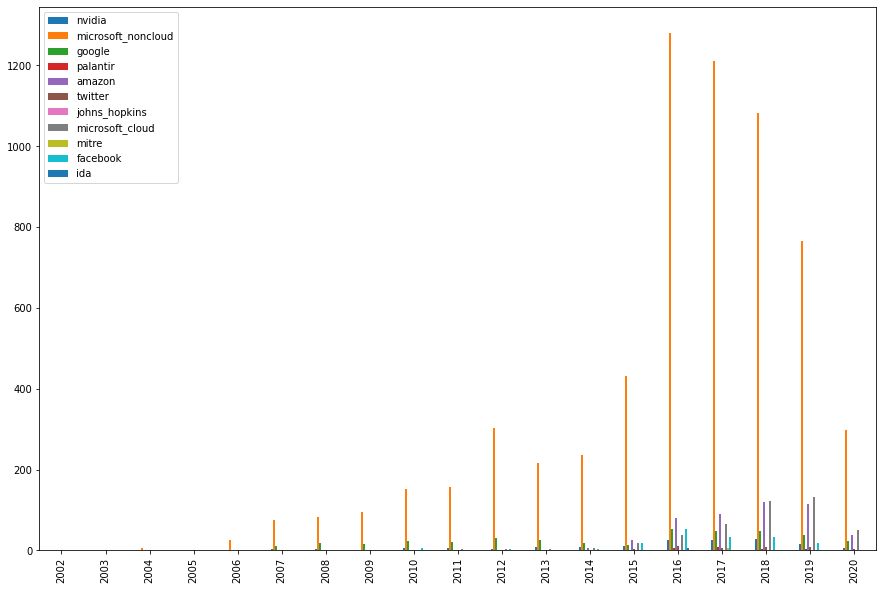

In [8]:
count_df.plot.bar(figsize=(15, 10))

In [9]:
sum_df = pd.DataFrame(
    {k: list(map(lambda x: x['sum'], v)) for k, v in contracts_by_year.items()},
    index=years
)

<AxesSubplot:>

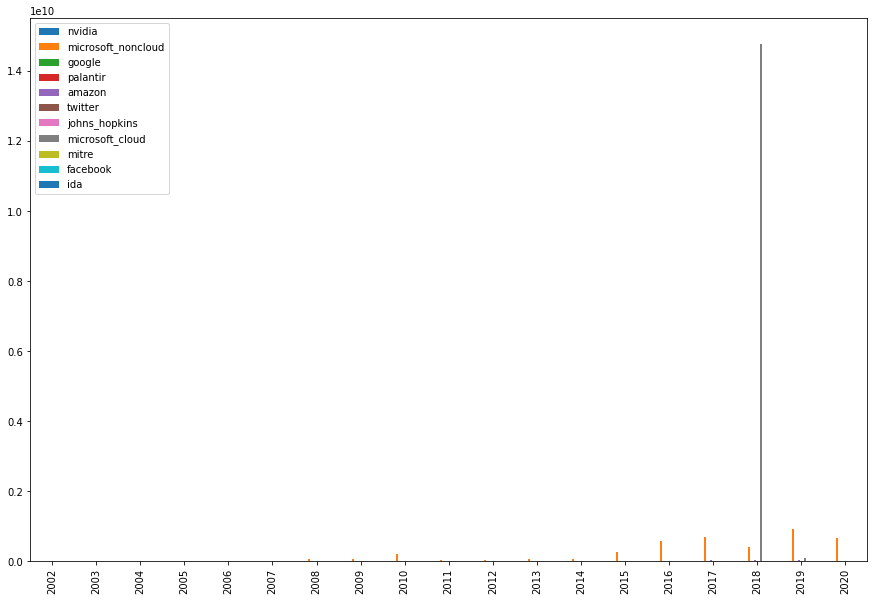

In [10]:
sum_df.plot.bar(figsize=(15, 10))

In [11]:
sum_df

,nvidia,microsoft_noncloud,google,palantir,amazon,twitter,johns_hopkins,microsoft_cloud,mitre,facebook,ida
2002,0.00,1.149975e+04,0.00,0.00,0.00,0.00,0.0,0.000000e+00,0.00,0.00,0.00
2003,0.00,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.000000e+00,0.00,0.00,0.00
2004,0.00,5.991030e+04,0.00,0.00,0.00,0.00,0.0,0.000000e+00,0.00,0.00,0.00
2005,0.00,9.634400e+02,0.00,0.00,0.00,0.00,0.0,0.000000e+00,0.00,0.00,0.00
2006,12487.50,7.497767e+05,0.00,0.00,0.00,0.00,0.0,0.000000e+00,0.00,0.00,0.00
2007,34954.50,6.761803e+06,464199.75,0.00,0.00,0.00,0.0,0.000000e+00,0.00,0.00,0.00
2008,11670.75,8.166116e+07,1357070.33,181617.51,0.00,0.00,0.0,0.000000e+00,0.00,0.00,0.00
2009,15452.85,6.974172e+07,843995.70,0.00,0.00,0.00,0.0,0.000000e+00,0.00,0.00,0.00
2010,415024.68,2.243728e+08,1058042.57,1356750.00,0.00,0.00,0.0,0.000000e+00,0.00,84479.12,0.00
2011,3402422.49,3.636526e+07,1145236.84,0.00,5016.90,0.00,0.0,0.000000e+00,0.00,8448.00,0.00
